<a href="https://colab.research.google.com/github/CHGROSJEAN/2024_MLEES/blob/main/Projet/Projet_Charlotte_Grosjean_GMM_5Stations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import libraries and data


In [1]:
# Import
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
import os
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
import seaborn as sns

from sklearn.preprocessing import StandardScaler



Download data sets

In [2]:
# Reading the Excel files
grandvennes = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/GrandVennes.xlsx")
riandpre = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/RiandPre.xlsx")
chandieu = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Chandieu.xlsx")
geopolis = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Geopolis.xlsx")
lexplore = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/LExplore.xlsx")
bethusy = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Bethusy.xlsx")
boisgentils = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/BoisGentils.xlsx")
elysee = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Elysee.xlsx")
pontaise = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Pontaise.xlsx")
rouvraie = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/Rouvraie.xlsx")
vclb = pd.read_excel("https://raw.githubusercontent.com/CHGROSJEAN/2024_MLEES/main/Projet/Stations/VersChezLesBlancs.xlsx")



# Displaying the first few rows of each dataset
print("Data from Grand-Vennes:")
print(grandvennes.head())

print("\nData from Riand-Pré:")
print(riandpre.head())

print("\nData from Chandieu:")
print(chandieu.head())

print("\nData from Geopolis:")
print(geopolis.head())

print("\nData from LExplore:")
print(lexplore.head())

print("\nData from Bethusy:")
print(bethusy.head())

print("\nData from Bois Gentils:")
print(boisgentils.head())

print("\nData from Elysée:")
print(elysee.head())

print("\nData from Pontaise:")
print(pontaise.head())

print("\nData from Rouvraie:")
print(rouvraie.head())

print("\nData from Vers-chez-les-Blanc:")
print(vclb.head())


Data from Grand-Vennes:
   Index             DateTime  Precipitation
0      1  07.01.2023 08:27:54              0
1      2  07.01.2023 08:30:54              0
2      3  07.01.2023 08:33:54              0
3      4  07.01.2023 08:36:54              0
4      5  07.01.2023 08:39:54              0

Data from Riand-Pré:
   Index             DateTime  Precipitation
0      1  09.11.2022 00:03:39              0
1      2  09.11.2022 00:06:39              0
2      3  09.11.2022 00:09:39              0
3      4  09.11.2022 00:12:39              0
4      5  09.11.2022 00:15:39              0

Data from Chandieu:
   Index             DateTime  Precipitation
0      1  30.11.2022 00:03:07              0
1      2  30.11.2022 00:06:07              0
2      3  30.11.2022 00:09:07              0
3      4  30.11.2022 00:12:07              0
4      5  30.11.2022 00:15:07              0

Data from Geopolis:
   Index             DateTime  Precipitation
0      1  11.11.2022 00:02:18              0
1      2  11

In [3]:
# Ensuring the 'DateTime' the column is of datetime type for both datasets
grandvennes['DateTime'] = pd.to_datetime(grandvennes['DateTime'], dayfirst=True)
riandpre['DateTime'] = pd.to_datetime(riandpre['DateTime'], dayfirst=True)
chandieu['DateTime'] = pd.to_datetime(chandieu['DateTime'], dayfirst=True)
geopolis['DateTime'] = pd.to_datetime(geopolis['DateTime'], dayfirst=True)
lexplore['DateTime'] = pd.to_datetime(lexplore['DateTime'], dayfirst=True)
bethusy['DateTime'] = pd.to_datetime(bethusy['DateTime'], dayfirst=True)
boisgentils['DateTime'] = pd.to_datetime(boisgentils['DateTime'], dayfirst=True)
elysee['DateTime'] = pd.to_datetime(elysee['DateTime'], dayfirst=True)
pontaise['DateTime'] = pd.to_datetime(pontaise['DateTime'], dayfirst=True)
rouvraie['DateTime'] = pd.to_datetime(rouvraie['DateTime'], dayfirst=True)
vclb['DateTime'] = pd.to_datetime(vclb['DateTime'], dayfirst=True)



# Setting the DateTime column as the index for easier time-based operations
grandvennes.set_index('DateTime', inplace=True)
riandpre.set_index('DateTime', inplace=True)
chandieu.set_index('DateTime', inplace=True)
geopolis.set_index('DateTime', inplace=True)
lexplore.set_index('DateTime', inplace=True)
bethusy.set_index('DateTime', inplace=True)
boisgentils.set_index('DateTime', inplace=True)
elysee.set_index('DateTime', inplace=True)
pontaise.set_index('DateTime', inplace=True)
rouvraie.set_index('DateTime', inplace=True)
vclb.set_index('DateTime', inplace=True)

# 2. Complex GMM with 5 stations

Complete the same process than with 2 station but with 5 stations


In [4]:

# Round down the DateTime to the previous minute (removes seconds, truncating)
grandvennes.index = grandvennes.index.floor('min')  # rounded to the nearest lower minute
riandpre.index = riandpre.index.floor('min')
bethusy.index = bethusy.index.floor('min')
pontaise.index = pontaise.index.floor('min')
geopolis.index = geopolis.index.floor('min')

# Resample both datasets to ensure they have data every 3 minutes
grandvennes_resampled = grandvennes.resample('3min').mean()
riandpre_resampled = riandpre.resample('3min').mean()
bethusy_resampled = bethusy.resample('3min').mean()
pontaise_resampled = pontaise.resample('3min').mean()
geopolis_resampled = geopolis.resample('3min').mean()


# Align both datasets to the common time period (intersection of their timestamps)
start_time = max(grandvennes_resampled.index.min(), riandpre_resampled.index.min(),bethusy_resampled.index.min(),
                 pontaise_resampled.index.min(),geopolis_resampled.index.min())


end_time = min(grandvennes_resampled.index.max(), riandpre_resampled.index.max(), bethusy_resampled.index.max(),
               pontaise_resampled.index.max(),geopolis_resampled.index.max())

grandvennes_aligned = grandvennes_resampled.loc[start_time:end_time]
riandpre_aligned = riandpre_resampled.loc[start_time:end_time]
bethusy_aligned = bethusy_resampled.loc[start_time:end_time]
pontaise_aligned = pontaise_resampled.loc[start_time:end_time]
geopolis_aligned = geopolis_resampled.loc[start_time:end_time]

# Drop rows with missing values from datasets
grandvennes_aligned = grandvennes_aligned.dropna()
riandpre_aligned = riandpre_aligned.dropna()
bethusy_aligned = bethusy_aligned.dropna()
pontaise_aligned = pontaise_aligned.dropna()
geopolis_aligned = geopolis_aligned.dropna()

# Now both datasets are aligned and cleaned. Viewing the cleaned and aligned data
print("Aligned and cleaned Grandvennes data:")
print(grandvennes_aligned.head())

print("Aligned and cleaned Riandpre data:")
print(riandpre_aligned.head())

print("Aligned and cleaned Bethusy data:")
print(bethusy_aligned.head())

print("Aligned and cleaned Pontaise data:")
print(pontaise_aligned.head())

print("Aligned and cleaned Geopolis data:")
print(geopolis_aligned.head())

Aligned and cleaned Grandvennes data:
                     Index  Precipitation
DateTime                                 
2023-01-07 08:27:00    1.0            0.0
2023-01-07 08:30:00    2.0            0.0
2023-01-07 08:33:00    3.0            0.0
2023-01-07 08:36:00    4.0            0.0
2023-01-07 08:39:00    5.0            0.0
Aligned and cleaned Riandpre data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  28489.0            0.0
2023-01-07 08:30:00  28490.0            0.0
2023-01-07 08:33:00  28491.0            0.0
2023-01-07 08:36:00  28492.0            0.0
2023-01-07 08:39:00  28493.0            0.0
Aligned and cleaned Bethusy data:
                       Index  Precipitation
DateTime                                   
2023-01-07 08:27:00  18409.0            0.0
2023-01-07 08:30:00  18410.0            0.0
2023-01-07 08:33:00  18411.0            0.0
2023-01-07 08:36:00  18412.0            0.0
2023-01-07 08:39:00  18413.

In [5]:
# Merge the datasets on the 'DateTime' index
combined_data = pd.concat(
    [
        grandvennes_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Grandvennes'}),
        riandpre_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Riandpre'}),
        bethusy_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Bethusy'}),
        pontaise_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Pontaise'}),
        geopolis_aligned[['Precipitation']].rename(columns={'Precipitation': 'Precipitation_Geopolis'})
    ],
    axis=1,
    join='inner'  # Ensures alignment on shared indices only
)

# Display the first few rows of the combined data
print("Combined Precipitation Data:")
print(combined_data.head())
print(combined_data.shape)



Combined Precipitation Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Pontaise  \
DateTime                                                             
2023-01-19 14:03:00                    0.0                    10.0   
2023-01-19 14:06:00                    0.0                    10.0   
2023-01-19 14:09:00                    0.0                    11.0   
2023-01-19 14:12:00                    0.0                    11.0   
2023-01-19 14:15:00             

In [6]:
# Calculate the index for the splits
train_size = int(0.7 * len(combined_data))  # 70% for training
val_size = int(0.15 * len(combined_data))  # 15% for validation
test_size = len(combined_data) - train_size - val_size  # 15% for testing

# Split the data sequentially
train_data = combined_data[:train_size]
val_data = combined_data[train_size:train_size + val_size]
test_data = combined_data[train_size + val_size:]

# Display the sizes of each dataset
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Display the first few rows of each dataset
print("\nTraining Data:")
print(train_data.head())

print("\nValidation Data:")
print(val_data.head())

print("\nTest Data:")
print(test_data.head())


Training set size: 46531
Validation set size: 9970
Test set size: 9972

Training Data:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Pontaise  \
DateTime                                                             
2023-01-19 14:03:00                    0.0                    10.0   
2023-01-19 14:06:00                    0.0                    10.0   
2023-01-19 14:09:00                    0.0                    11.0   
2023-01-19 14:12:00                    0.0  

In [7]:
# Extract X for each dataset
# For training data
X_train = train_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Pontaise', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# For validation data
X_valid = val_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Pontaise', 'Precipitation_Geopolis']]  # Features (precipitation from both stations)

# For test data
X_test = test_data[['Precipitation_Grandvennes', 'Precipitation_Riandpre', 'Precipitation_Bethusy', 'Precipitation_Pontaise', 'Precipitation_Geopolis']]

# Display the first few rows of the extracted data
print("X_train:")
print(X_train.head())

print("\nX_valid:")
print(X_valid.head())

print("\nX_test:")
print(X_test.head())

X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                        0.0                     5.0   
2023-01-19 14:06:00                        0.0                     5.0   
2023-01-19 14:09:00                        0.0                     2.0   
2023-01-19 14:12:00                        0.0                     1.0   
2023-01-19 14:15:00                        0.0                     0.0   

                     Precipitation_Bethusy  Precipitation_Pontaise  \
DateTime                                                             
2023-01-19 14:03:00                    0.0                    10.0   
2023-01-19 14:06:00                    0.0                    10.0   
2023-01-19 14:09:00                    0.0                    11.0   
2023-01-19 14:12:00                    0.0                    11.0   
2023-01-19 14:15:00                    0.0          

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

X_valid_scaled = scaler.transform(X_valid)
X_valid = pd.DataFrame(X_valid_scaled, columns=X_valid.columns, index=X_valid.index)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# Display the first few rows of the scaled data to verify
print("Scaled X_train:")
print(X_train.head())

print("\nScaled X_valid:")
print(X_valid.head())

print("\nScaled X_test:")
print(X_test.head())

Scaled X_train:
                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                  -0.043502                1.666410   
2023-01-19 14:06:00                  -0.043502                1.666410   
2023-01-19 14:09:00                  -0.043502                0.616372   
2023-01-19 14:12:00                  -0.043502                0.266359   
2023-01-19 14:15:00                  -0.043502               -0.083654   

                     Precipitation_Bethusy  Precipitation_Pontaise  \
DateTime                                                             
2023-01-19 14:03:00              -0.016561                2.433748   
2023-01-19 14:06:00              -0.016561                2.433748   
2023-01-19 14:09:00              -0.016561                2.684332   
2023-01-19 14:12:00              -0.016561                2.684332   
2023-01-19 14:15:00              -0.016561   

**Visualization of distributions of all subsets**

(46531, 5) (9970, 5) (9972, 5)


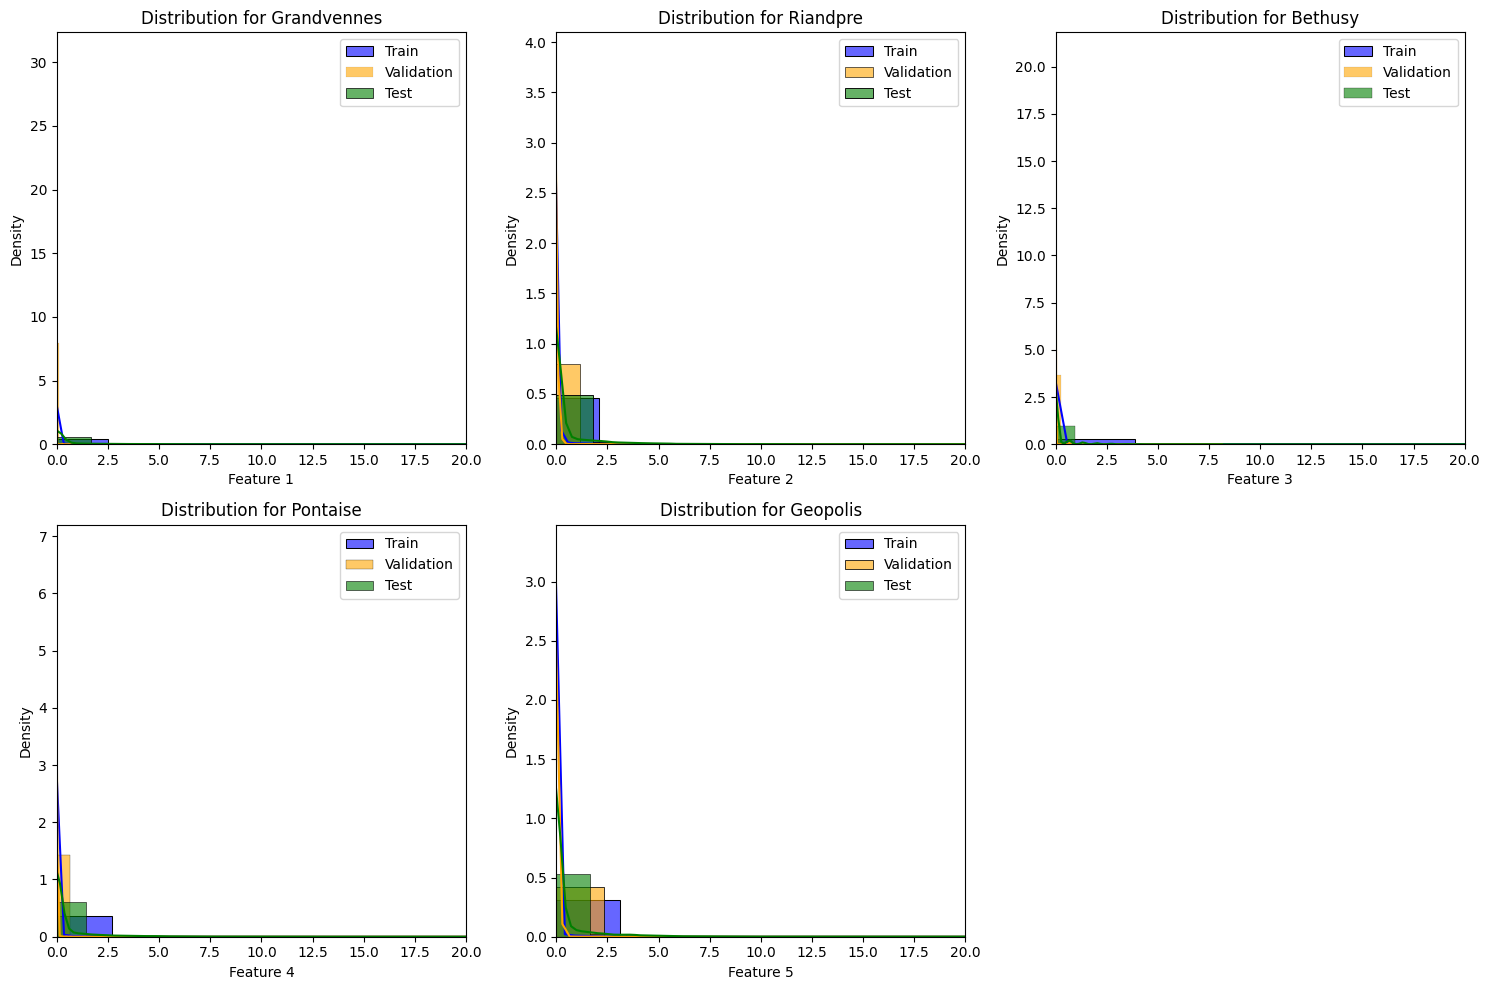

In [9]:
def plot_distributions(X_train, X_valid, X_test, feature_names=None, bins=30):
    """
    Visualise les distributions des ensembles d'entraînement, de validation et de test.

    Parameters:
    - X_train, X_valid, X_test : Arrays numpy ou pandas DataFrames des données.
    - feature_names : Liste des noms des caractéristiques (facultatif, pour un affichage personnalisé).
    - bins : Nombre de bins pour l'histogramme.
    """
    # Convertir en numpy si nécessaire
    if not isinstance(X_train, np.ndarray):
        X_train = X_train.values
    if not isinstance(X_valid, np.ndarray):
        X_valid = X_valid.values
    if not isinstance(X_test, np.ndarray):
        X_test = X_test.values

    # Check
    if X_train.shape[1] != X_valid.shape[1] or X_train.shape[1] != X_test.shape[1]:
        raise ValueError("Les données d'entraînement, de validation et de test doivent avoir le même nombre de colonnes.")

    # gerenate feature names
    num_features = X_train.shape[1]
    if feature_names is None or len(feature_names) != num_features:
        feature_names = [f"Feature {i+1}" for i in range(num_features)]

    rows = (num_features + 2) // 3
    plt.figure(figsize=(15, 5 * rows))

    for i in range(num_features):
        plt.subplot(rows, 3, i + 1)

        # distribution of each sets
        sns.histplot(X_train[:, i], kde=True, color='blue', label='Train', bins=bins, stat='density', alpha=0.6)
        sns.histplot(X_valid[:, i], kde=True, color='orange', label='Validation', bins=bins, stat='density', alpha=0.6)
        sns.histplot(X_test[:, i], kde=True, color='green', label='Test', bins=bins, stat='density', alpha=0.6)

        plt.title(f'Distribution for {station_names[i]}')
        plt.xlabel(feature_names[i])
        plt.ylabel('Density')
        plt.legend()

        # Axis limits
        plt.xlim(0, 20)

    plt.tight_layout()
    plt.show()

    # Station names
station_names = ["Grandvennes", "Riandpre", "Bethusy", "Pontaise", "Geopolis"]


# Check shape of data
print(X_train.shape, X_valid.shape, X_test.shape)

# Plot
plot_distributions(X_train, X_valid, X_test)


Evaluation of range of n_component

In [10]:
# Range of components to evaluate
component_range = [10,20,30,40,50,60,70,80,90,100]

# Store results
models = {}
bic_scores = []
silhouette_scores = []

# Loop through the range of components
for n_components in component_range:
    # Create and fit the Gaussian Mixture Model
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_train)  # Assuming X_train is your data

    # Store the model and metrics
    models[n_components] = gmm
    bic_scores.append(gmm.bic(X_train))

    # Predict cluster labels
    labels = gmm.predict(X_train)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train, labels)
    silhouette_scores.append(silhouette)



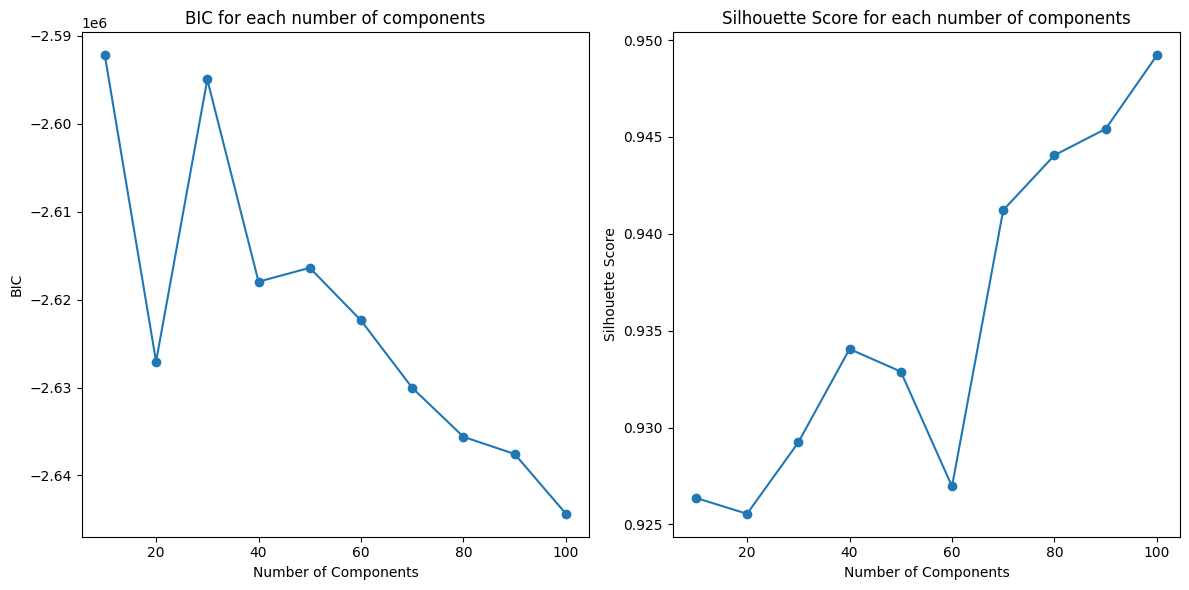

Best number of components: 100 based on BIC


In [11]:
# Plot BIC, and Silhouette Score for each number of components
plt.figure(figsize=(12, 6))


# Plot BIC
plt.subplot(1, 2, 1)
plt.plot(component_range, bic_scores, marker='o')
plt.title('BIC for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('BIC')

# Plot Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(component_range, silhouette_scores, marker='o')
plt.title('Silhouette Score for each number of components')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')

plt.tight_layout()

# Save the figure as a PDF
output_path = "plot_bic_silhouette_full.pdf"
plt.savefig(output_path, format='pdf')


plt.show()

# Select the best model based on the criteria you prefer (AIC, BIC, or silhouette score)
best_n_components = component_range[np.argmin(bic_scores)]
best_gmm_model = models[best_n_components]
print(f"Best number of components: {best_n_components} based on BIC")


Testing combination of n_component and covariance_type

In [ ]:
#search for best combination of values for both the number of clusters
#and the covariance_type hyperparameter:

min_bic = np.infty

for k in range(95, 105):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X_train).bic(X_train)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type

print('best_k')
print(best_k)
print('best_covariance_type')
print(best_covariance_type)



Initialization of model

In [ ]:
# Initialize the Gaussian Mixture Model
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=42)

In [ ]:
# Fit the model
gmm.fit(X_train)

GaussianMixture(n_components=7, random_state=42)

In [ ]:
# Print the GMM parameters
print("Means of the components:\n", gmm.means_)
print("\nCovariances of the components:\n", gmm.covariances_)
print("\nWeights of the components:\n", gmm.weights_)

# Predict the component labels for each data point
component = gmm.predict(X_train)
proba = gmm.predict_proba(X_train)

# Display the predicted labels
print("Predicted component labels for the data points:\n", labels)
print("Predicted probabilities for each component:\n", proba)

Means of the components:
 [[ 2.56939155e-02  3.65710158e-01 -1.65606464e-02  2.42843015e-01
   2.18316454e-01]
 [ 6.73882734e+01  5.76684626e+01  1.04538372e+02  5.83141265e+01
   3.14731307e+01]
 [ 4.58791740e+00  6.70464554e+00  1.90230334e+00  6.71941604e+00
   7.10275676e+00]
 [ 4.76909277e+01  3.91575028e+01  6.30421858e+00  1.58836958e+01
   7.62363261e+00]
 [-4.35024122e-02 -8.36537500e-02 -1.65606464e-02 -7.20987599e-02
  -6.31985207e-02]
 [ 1.03464208e+00  2.47723976e+00  4.04268280e-02  2.26418136e+00
   1.80602356e+00]
 [ 4.01169142e+01  3.29050551e+01  6.43118803e+01  6.32631734e+01
   6.77833079e+01]]

Covariances of the components:
 [[[ 2.65653466e-02 -9.31085611e-03 -2.38039234e-28 -1.24680242e-03
   -8.40925046e-04]
  [-9.31085611e-03  3.92261129e-01 -3.40770922e-27  1.73771975e-01
    1.43955588e-01]
  [-2.38123582e-28 -3.40764596e-27  1.00000000e-06 -2.24763146e-27
   -2.03024909e-27]
  [-1.24680242e-03  1.73771975e-01 -2.24771845e-27  2.39874297e-01
    1.60102537e-0

NameError: name 'labels' is not defined

In [ ]:
# Evaluate the log-likelihood of the trained GMM
log_likelihood = gmm.score(X_train)
print(f'Log-Likelihood: {log_likelihood}')

# Get the labels predicted by the GMM
labels = gmm.predict(X_train)

# Compute silhouette score
silhouette = silhouette_score(X_train, labels)
print(f'Silhouette Score: {silhouette}')


Log-Likelihood: 27.763927856251748
Silhouette Score: 0.9139591930021677


In [ ]:
Valid_score = gmm.score(X_valid)  # Log-likelihood score on validation data
Valid_labels = gmm.predict(X_valid)  # Cluster labels for validation data
silhouette = silhouette_score(X_valid, Valid_labels)  # Silhouette score

print(f"Log-likelihood on validation set: {Valid_score}")
print(f"Silhouette score on validation set: {silhouette}")

Log-likelihood on validation set: 29.056089784321657
Silhouette score on validation set: 0.9772030879931295


In [ ]:
Test_score = gmm.score(X_test)  # Log-likelihood score on test data
Test_labels = gmm.predict(X_test)  # Cluster labels for test data
silhouette = silhouette_score(X_test, Test_labels)  # Silhouette score

print(f"Log-likelihood on test set: {Test_score}")
print(f"Silhouette score on test set: {silhouette}")


Log-likelihood on test set: 16.274602719570282
Silhouette score on test set: 0.5721501520901691


In [ ]:
# Calculate BIC for training data
train_bic = gmm.bic(X_train)
print(f"BIC (Train): {train_bic}")

# Similarly, calculate BIC for validation and test data
val_bic = gmm.bic(X_valid)
print(f"BIC (Validation): {val_bic}")

test_bic = gmm.bic(X_test)
print(f"BIC (Test): {test_bic}")


BIC (Train): -2582197.4645492267
BIC (Validation): -578034.1592633822
BIC (Test): -323236.3763181918


**Anomaly identification**

In [ ]:
# Compute log-probabilities for data
log_probs = gmm.score_samples(X_train)

In [ ]:
threshold = np.percentile(gmm.score_samples(X_train), 5)  # 5th percentile
anomalies = X_train[log_probs < threshold]
print(anomalies.shape)
print(anomalies.head)

(2311, 5)
<bound method NDFrame.head of                      Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                  -0.043502                1.666410   
2023-01-19 14:06:00                  -0.043502                1.666410   
2023-01-19 14:09:00                  -0.043502                0.616372   
2023-01-19 14:12:00                  -0.043502                0.266359   
2023-01-19 14:15:00                  -0.043502               -0.083654   
...                                        ...                     ...   
2023-07-30 06:57:00                   0.270865               -0.083654   
2023-07-30 07:18:00                   0.270865               -0.083654   
2023-07-30 07:27:00                  -0.043502               -0.083654   
2023-07-30 15:12:00                  -0.043502               -0.083654   
2023-07-30 20:42:00                  -0.043502               -0.083654  

In [ ]:
# Assume X_train is a DataFrame with columns representing the stations
# log_probs: the log-probability scores computed by the GMM
log_probs = gmm.score_samples(X_train)

# Define the global threshold as the 5th percentile
threshold = np.percentile(log_probs, 5)

# Initialize a DataFrame to store anomalies
anomaly_df = pd.DataFrame(index=X_train.index)

# Determine anomalies for each station
for station in X_train.columns:
    # Station-specific threshold: can be adjusted here if needed
    station_threshold = threshold  # Use the global threshold for each station
    anomaly_df[station] = (X_train[station] < station_threshold).astype(int)

# Display the anomaly DataFrame
print(anomaly_df.head())


                     Precipitation_Grandvennes  Precipitation_Riandpre  \
DateTime                                                                 
2023-01-19 14:03:00                          1                       1   
2023-01-19 14:06:00                          1                       1   
2023-01-19 14:09:00                          1                       1   
2023-01-19 14:12:00                          1                       1   
2023-01-19 14:15:00                          1                       1   

                     Precipitation_Bethusy  Precipitation_Pontaise  \
DateTime                                                             
2023-01-19 14:03:00                      1                       1   
2023-01-19 14:06:00                      1                       1   
2023-01-19 14:09:00                      1                       1   
2023-01-19 14:12:00                      1                       1   
2023-01-19 14:15:00                      1                   

# **Visualization**

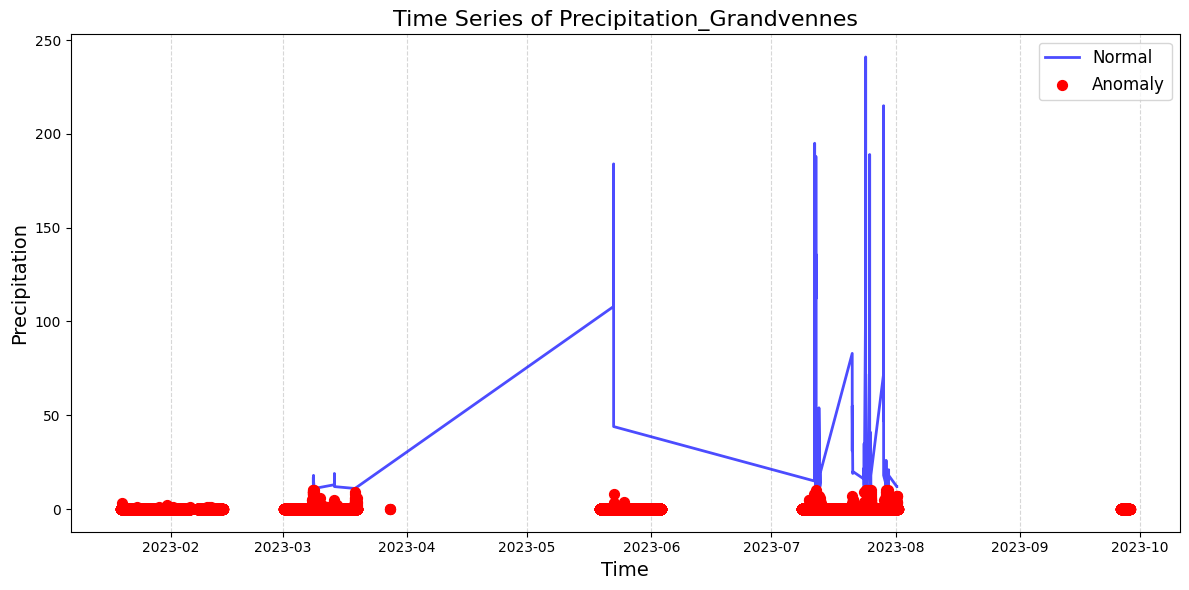

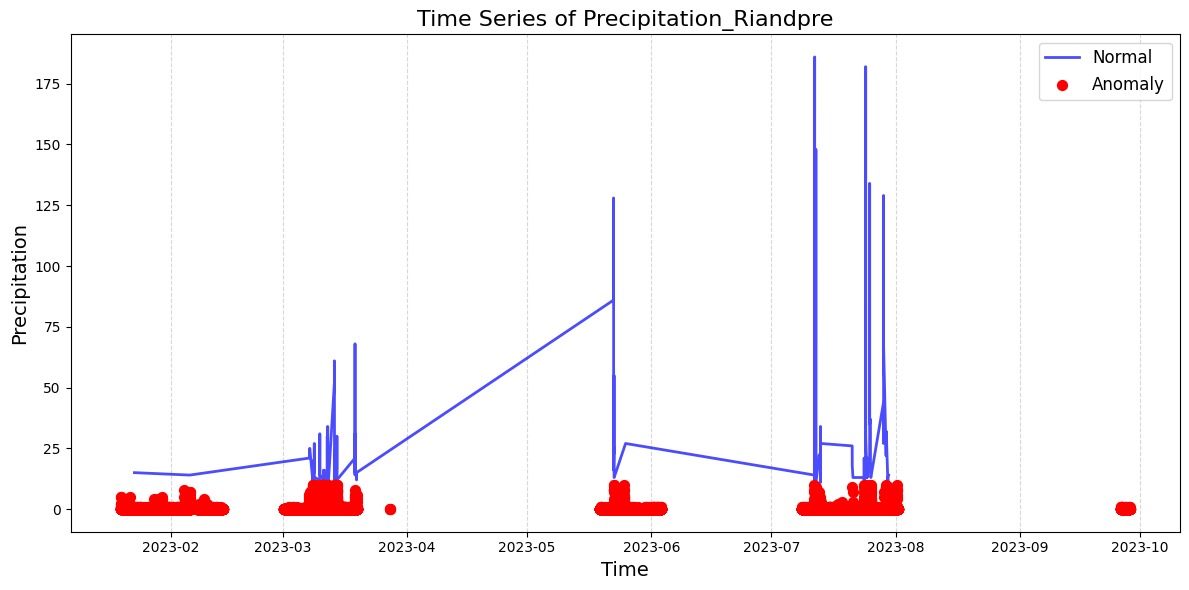

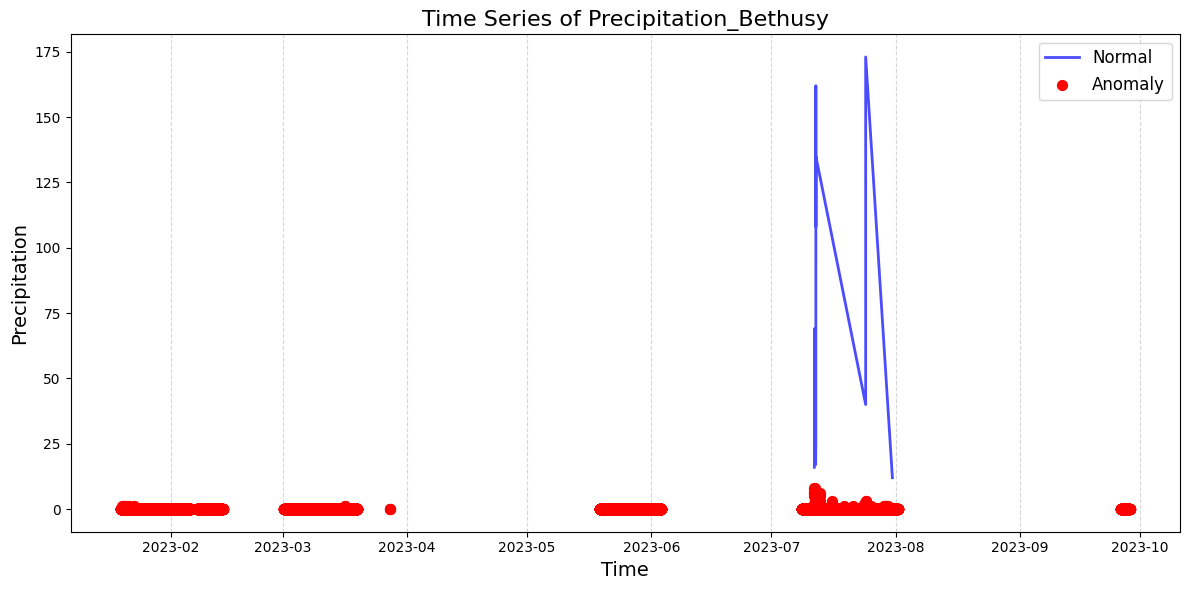

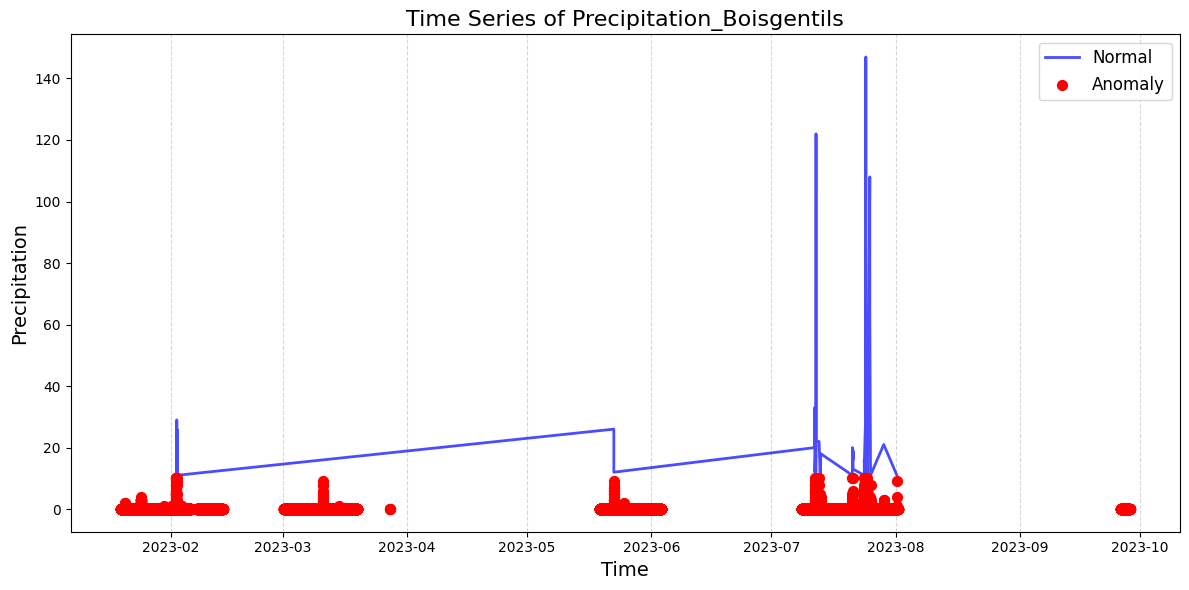

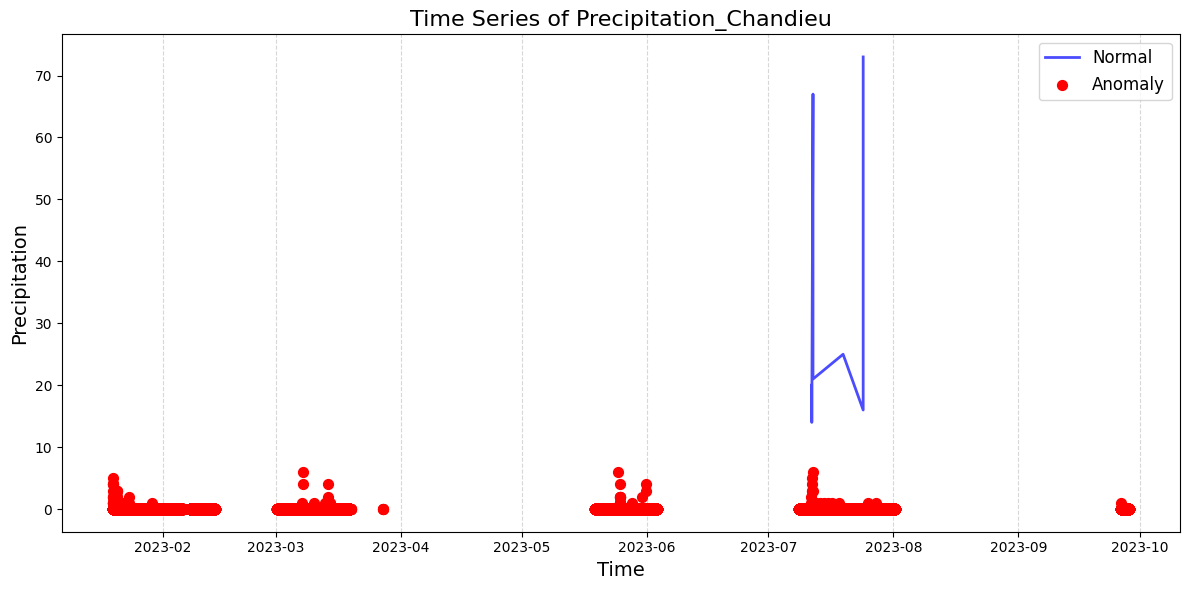

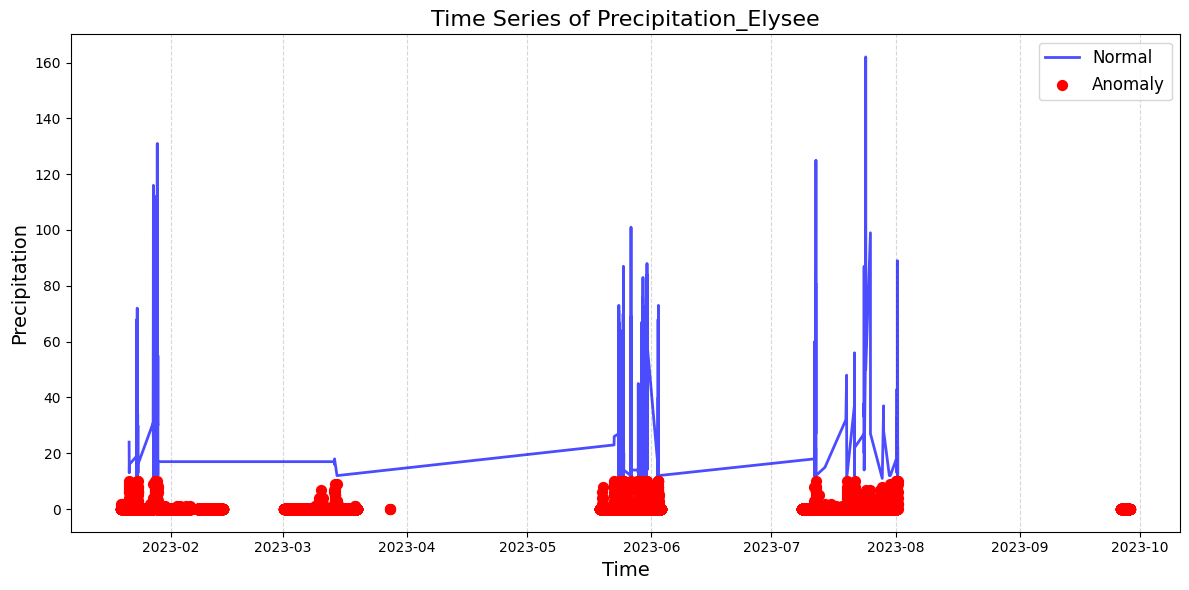

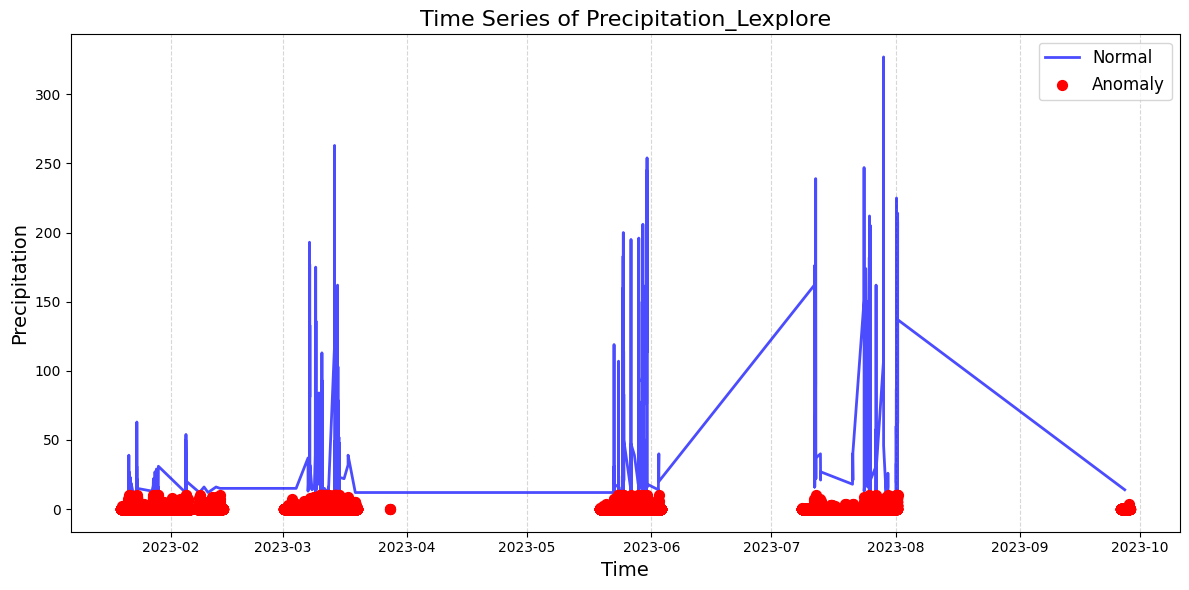

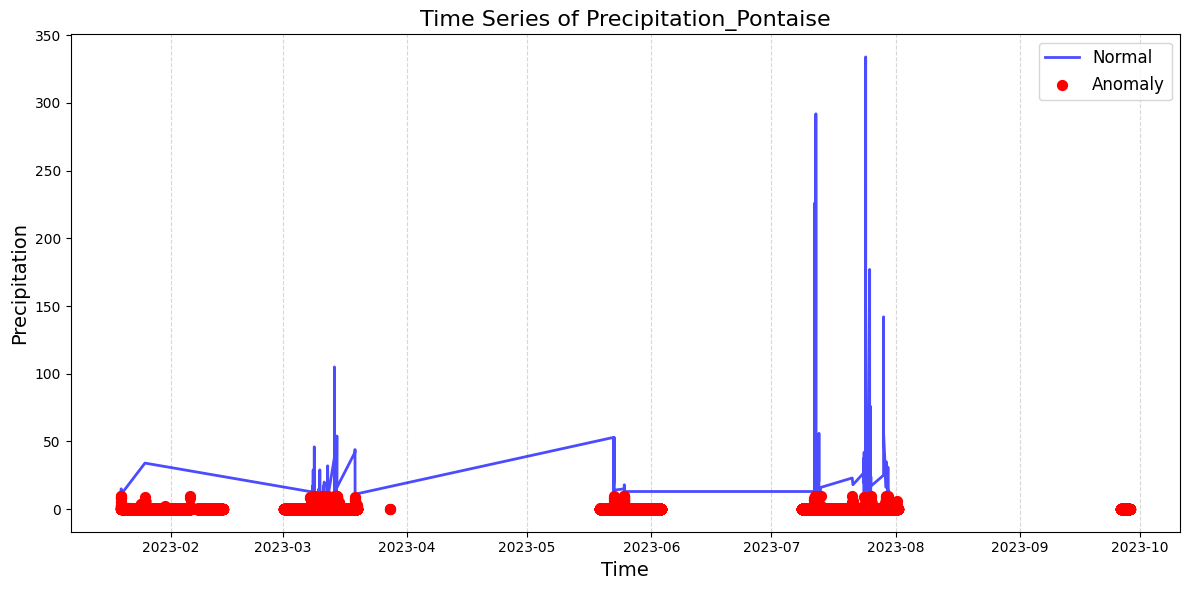

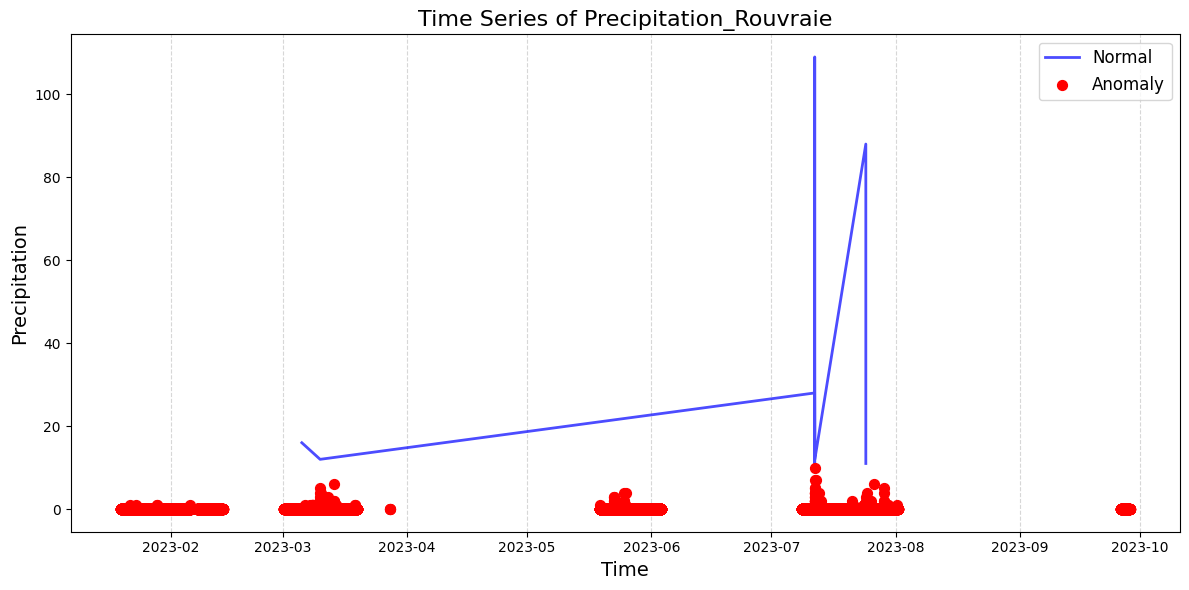

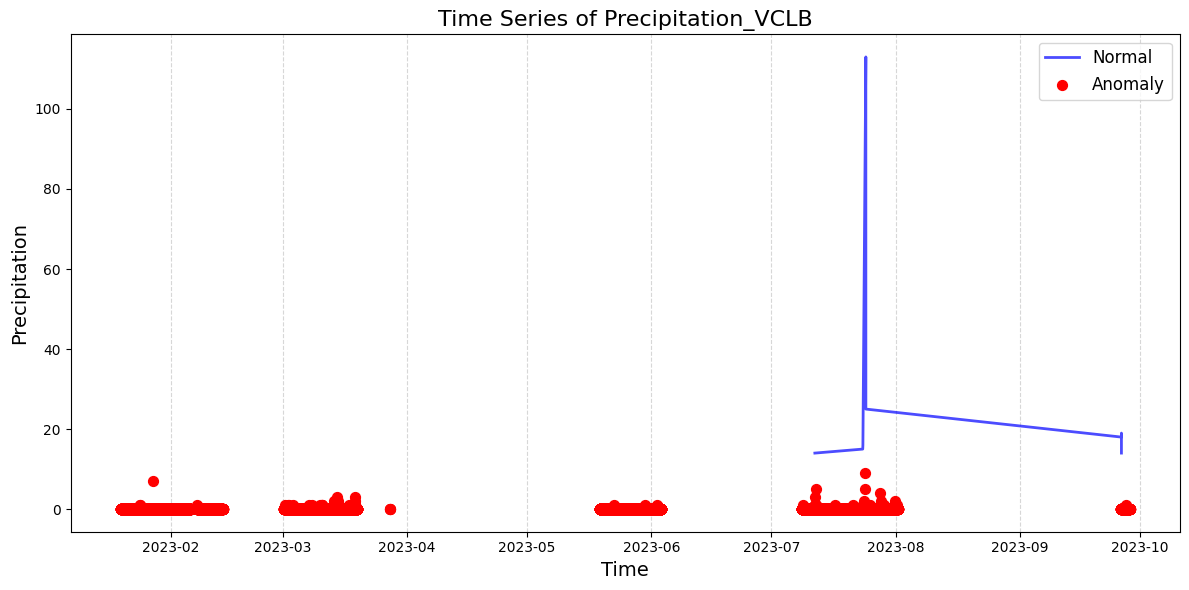

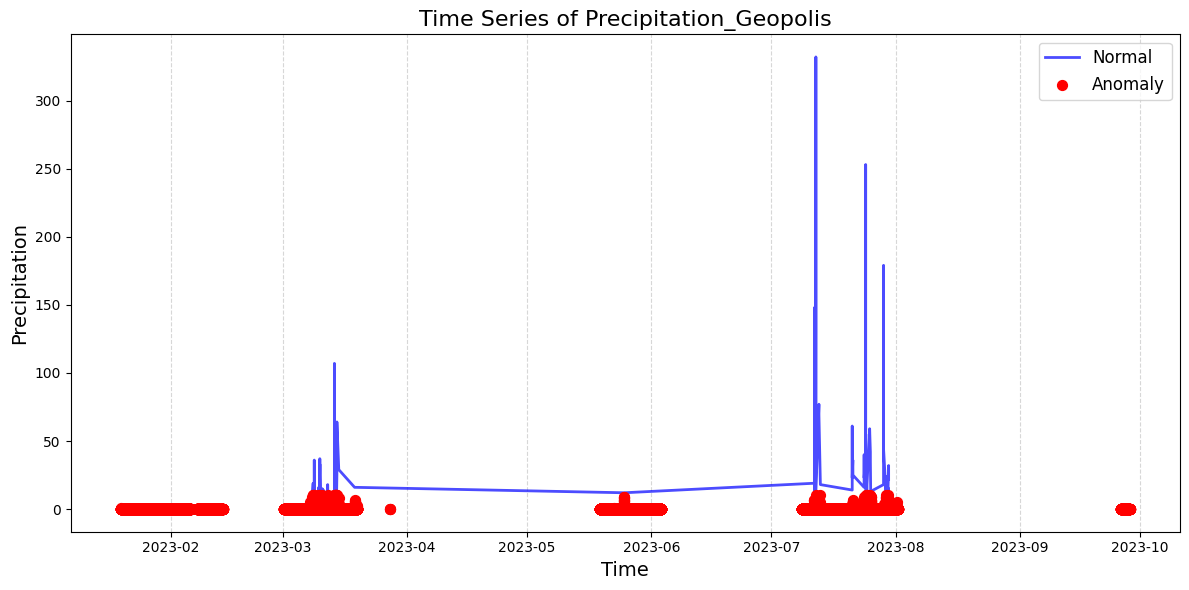

In [ ]:
import matplotlib.pyplot as plt

def plot_time_series_with_anomalies(X_train, anomaly_df, time_index, start_date='2023-07-01 00:00:00', end_date='2023-07-30 23:00:00'):
    """
    Plot time series for each station, highlighting anomalies in a different color.
    Only data from the specified date range (default July 2023) is plotted.

    Parameters:
    - X_train: DataFrame containing station data (columns = stations).
    - anomaly_df: DataFrame containing anomaly flags (1 = anomaly, 0 = normal) for each station.
    - time_index: DatetimeIndex or time vector corresponding to the observations.
    - start_date: Start date for filtering the data (default is '2023-07-01').
    - end_date: End date for filtering the data (default is '2023-07-31').
    """
    # Filter the data to only include the specified date range
    mask = (time_index >= start_date) & (time_index <= end_date)
    X_train_filtered = X_train[mask]
    anomaly_df_filtered = anomaly_df[mask]
    time_index_filtered = time_index[mask]

    stations = X_train_filtered.columns

    for station in stations:
        plt.figure(figsize=(12, 6))

        # Normal data
        normal_data = X_train_filtered[station][anomaly_df_filtered[station] == 0]
        normal_time = time_index_filtered[anomaly_df_filtered[station] == 0]

        # Anomalous data
        anomaly_data = X_train_filtered[station][anomaly_df_filtered[station] == 1]
        anomaly_time = time_index_filtered[anomaly_df_filtered[station] == 1]

        # Plot normal data
        plt.plot(normal_time, normal_data, label="Normal", color="blue", alpha=0.7, lw=2)

        # Plot anomalies
        plt.scatter(anomaly_time, anomaly_data, label="Anomaly", color="red", s=50, zorder=5)

        # Add labels and title
        plt.title(f"Time Series of {station} (July 2023)", fontsize=16)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel("Precipitation", fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

# Usage example
time_index = X_train.index  # Assuming X_train already has a time-based index
plot_time_series_with_anomalies(X_train, anomaly_df, time_index)
